# Overall model evaluation
*This evaluation is carried out by sequantially testing the binary and multiclass classifiers. Only the true positive are passed to the second one.* 

## Library Declaration

In [1]:
import pandas as pd
import joblib
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.text_preprocessing import preprocess_text

## Test Set Preparation

In [2]:
df_test = pd.read_csv("../dataset/test_set.csv")
df_test["text"] = df_test["text"].apply(preprocess_text)

df_train = pd.read_csv("../dataset/training_set.csv")
df_filtered = df_train[df_train["multiclass_label"] != "not_cyberbullying"].copy()
label2id = {label: idx for idx, label in enumerate(sorted(df_filtered["multiclass_label"].unique()))}

X_test_text_1 = df_test["text"]
y_test_1 = df_test["binary_label"].map({"cyberbullying": 1, "not_cyberbullying": 0}).values
tfidf_vectorizer_1 = joblib.load("../model/tfidf_vocabulary.pkl")
X_test_tfidf_1 = tfidf_vectorizer_1.transform(X_test_text_1)

X_test_text_2 = df_test['text']
y_test_2 = df_test["multiclass_label"].map(label2id)
tfidf_vectorizer_2 = joblib.load("../model/tfidf_vocabulary_multiclass.pkl")
X_test_tfidf_2 = tfidf_vectorizer_2.transform(X_test_text_2)

file_name1 = f"../model/grid_search_binary_f1/RandomForest_TF-IDF.pkl"
clf1 = joblib.load(file_name1)
file_name2 = f"../model/grid_search_multiclass/RandomForest_TF-IDF_multiclass.pkl"
clf2 = joblib.load(file_name2)

## Sequential Classification and Model Evaluation

=== Classification Report: Binary ===
                   precision    recall  f1-score   support

not_cyberbullying       0.43      0.75      0.55      1589
    cyberbullying       0.94      0.80      0.87      7950

         accuracy                           0.79      9539
        macro avg       0.69      0.78      0.71      9539
     weighted avg       0.86      0.79      0.81      9539

=== Confusion Matrix: Binary ===


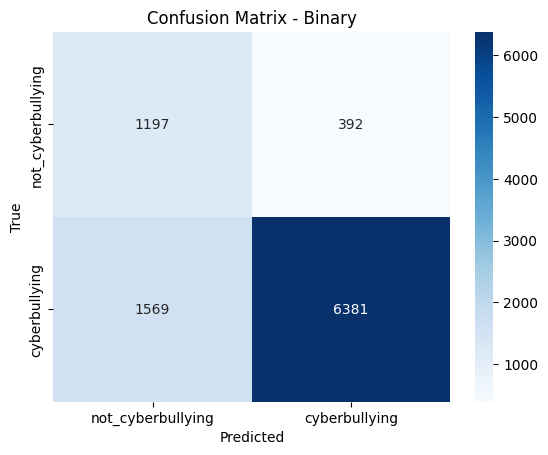

=== Classification Report: Multiclass (only true positives) ===
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1561
         1.0       1.00      0.98      0.99      1570
         2.0       0.94      0.94      0.94      1336
         3.0       0.75      0.81      0.78       424
         4.0       0.99      0.98      0.99      1490

    accuracy                           0.96      6381
   macro avg       0.93      0.94      0.94      6381
weighted avg       0.97      0.96      0.96      6381

=== Confusion Matrix: Multiclass (only true positives) ===


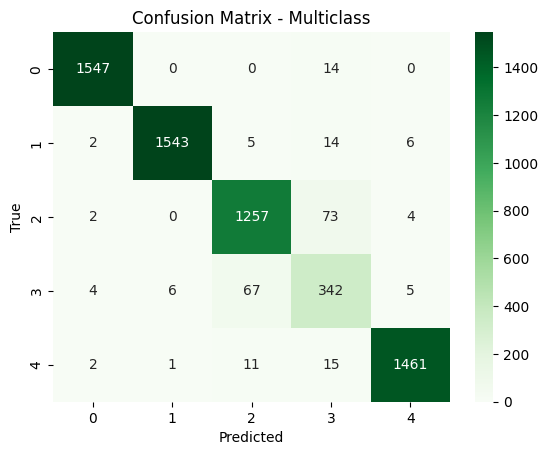

=== Overall Accuracy (binary + multiclass chaining) ===
Correct: 7347 over 9539 = 0.7702


In [3]:
# Classificazione binaria 
y_pred_binary = clf1.predict(X_test_tfidf_1)
print("=== Classification Report: Binary ===")
print(classification_report(y_test_1, y_pred_binary, target_names=["not_cyberbullying", "cyberbullying"]))

print("=== Confusion Matrix: Binary ===")
cm_binary = confusion_matrix(y_test_1, y_pred_binary)
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', xticklabels=["not_cyberbullying", "cyberbullying"], yticklabels=["not_cyberbullying", "cyberbullying"])
plt.title("Confusion Matrix - Binary")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classificazione multiclasse sui TP 
true_positive_mask = (y_test_1 == 1) & (y_pred_binary == 1)
X_test_tfidf_2_filtered = X_test_tfidf_2[true_positive_mask]
y_test_2_filtered = y_test_2[true_positive_mask]
y_pred_multiclass = clf2.predict(X_test_tfidf_2_filtered)

print("=== Classification Report: Multiclass (only true positives) ===")
print(classification_report(y_test_2_filtered, y_pred_multiclass))

print("=== Confusion Matrix: Multiclass (only true positives) ===")
cm_multi = confusion_matrix(y_test_2_filtered, y_pred_multiclass)
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Multiclass")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Accuracy complessiva 
true_negative = ((y_test_1 == 0) & (y_pred_binary == 0)).sum()
true_positive_multiclass = (y_pred_multiclass == y_test_2_filtered).sum()
total_test_samples = len(y_test_1)
overall_correct = true_negative + true_positive_multiclass
overall_accuracy = overall_correct / total_test_samples

print(f"=== Overall Accuracy (binary + multiclass chaining) ===\nCorrect: {overall_correct} over {total_test_samples} = {overall_accuracy:.4f}")

## True Positive Dataset Saving

In [4]:
true_positives = df_test[true_positive_mask]
true_positives.to_csv("../dataset/true_positive.csv", index=False)